# CXR14 EDA

This is an exploratory data analysis of the Chest X-ray CXR-14 dataset from the NIHCC.

## Table of Contents
_"You can observe a lot by just watching." ~Yogi Berra_

1. [Setup and load data](#1.-Setup)
2. [Data cleaning](#2.-Data-cleaning)
3. [Begin EDA](#3.-Begin-EDA)
    - How many rows and columns are the data? What does each row of data represent?
    - What are the names and data types for each column?
    - How many x-rays from how many patients are there?
    - For numeric variables,
        - What are the ranges and typical values?
        - Are there extreme values or outliers?
        - Are there any patterns of outliers? Or, what additional questions are raised?
        - Are there correlations among numeric variables?
    - For discrete (categorical) variables,
        - How many categories are present, and what are they?
        - How many x-rays are associated with each category?
    - Are any data transformations necessary or helpful for EDA?
        - One-hot encoding for Finding Labels
        - Total sum of Finding Labels per x-ray 
        - Combined width-by-height combinations and counts
4. Explore target variable: Findings Labels
    - What is the prevalence of each pathology?
    - What is the proportion of x-rays that are normal vs. abnormal?
    - Do x-rays have more than one finding? If so, how many?
    - What are common co-morbidities for each pathology wherever more than one is found? (pie chart [example](https://www.kaggle.com/sbernadac/lung-deseases-data-analysis))
5. Show examples of actual chest x-ray images
    - What do the chest x-rays look like?
    - What are examples of x-rays with non-normal findings?
    - (if possible to do & show) What are some examples of image augmentation that can potentially improve models?
        - Horizontal inversion, or rotation
        - Shearing or blurring
        - Brightness and contrast
        - (Ajdust gamma)
        - (Heatmap)
6. Exploratory, simple binary model
    - Using logistic regression, without looking at x-ray images, what can Age, Gender, and Follow-up # tell us about the likelihood of a non-normal finding?


## 1. Setup

### Load Python packages used for analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing the data
import seaborn as sns # prettier visuals of data, built on matplotlib
from collections import OrderedDict # to preserve column order when creating DFs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker # for customizing axis tick marks in plots

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# Uncomment to check pandas environment
# pd.show_versions() # show versions of pandas and all of its dependencies
# pd.__version__ # show pandas version only

### Load data
Source: NIH  
File: Data_Entry_2017.csv  
Repo: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345  

In [4]:
xrayDataIn = pd.read_csv('../data/Data_Entry_2017.csv')

In [5]:
xrayDataIn.shape

(112120, 12)

**How many rows and columns are the data?**

The original X-ray data file provides 112,120 rows and 12 columns.

In [6]:
xrayDataIn.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


**What does each row of data represent?**

Each row is a single X-ray, each with the following information:

- Image Index - unique image PNG filename for each X-ray
- Finding Labels - pipe-separated list of pathologies detected in X-ray, or "No Finding" if none
- Follow-up # - zero for first X-ray per patient, and incremented by one for subsequent X-rays
- Patient Age - age, in years
- Patient ID
- Patient Gender - Category with two classes:
    - F for Female
    - M for Male
- View Position - Category with two classes:
    - PA for posterioranterior position
    - AP for anteroposterior position
- OriginalImage\[Width - image width, in pixels
- Height\] - image height, in pixels
- OriginalImagePixelSpacing\[x - horizontal image pixel spacing
- y\] - vertical image pixel spacing
- Unnamed: 11 - junk

In [7]:
# list each column by name, non-null counts, and data type
xrayDataIn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
Image Index                    112120 non-null object
Finding Labels                 112120 non-null object
Follow-up #                    112120 non-null int64
Patient ID                     112120 non-null int64
Patient Age                    112120 non-null int64
Patient Gender                 112120 non-null object
View Position                  112120 non-null object
OriginalImage[Width            112120 non-null int64
Height]                        112120 non-null int64
OriginalImagePixelSpacing[x    112120 non-null float64
y]                             112120 non-null float64
Unnamed: 11                    0 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


Observations:
- Total of 112,120 rows, one per X-ray
- No missing data, with exception of empty column 'Unnamed: 11'
- Categories 'Patient Gender' and 'View Position' imported with type *object*; change to type *category*

## 2. Data cleaning

- Copy X-ray data set and drop unused column
- Clean up data types and column names
- Parse "Finding Labels" into separate columns for each pathology
- Create column to show sum of total pathologies found for each X-ray
- Create column with binary flag if Non-normal X-ray

In [8]:
# copy dataframe and drop unused column
xrays = xrayDataIn.drop('Unnamed: 11', axis=1)

In [9]:
# change data type to category
for col in ['Patient Gender','View Position']:
    xrays[col] = xrays[col].astype('category')

# simplify column names
xrays.rename(columns = {'OriginalImage[Width':'ImgWidth'}, inplace = True)
xrays.rename(columns = {'Height]':'ImgHeight'}, inplace = True)
xrays.rename(columns = {'OriginalImagePixelSpacing[x':'ImgPxSpaceX'}, inplace = True)
xrays.rename(columns = {'y]':'ImgPxSpaceY'}, inplace = True)

In [10]:
# create new column for each disease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis',
                  'Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

# for each pathology, for each row, set to 1 if label is found, or 0 if not found
for pathology in pathology_list :
    xrays.loc[:, pathology] = xrays['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

# Code block credited to Stephane Bernadec's Kaggle kernel.

In [11]:
# create column for total number of pathologies in each X-ray; axis=1 to sum by columns
xrays.loc[:, 'TotalPathos'] = xrays.iloc[:, 11:26].sum(axis=1)

# create column with binary flag if Non-normal X-ray
xrays.loc[:, 'Non-normal'] = xrays['TotalPathos'].apply(lambda x: 1 if (x > 0) else 0)

# create column with combined image width by height string
xrays.loc[: ,"ImageWxH"] = xrays["ImgWidth"].map(str) + "x" + xrays["ImgHeight"].map(str)

In [12]:
xrays.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImgWidth,ImgHeight,ImgPxSpaceX,...,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal,ImageWxH
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,1,1,2682x2749
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,2,1,2894x2729
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,2,1,2500x2048
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,2500x2048
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,1,2582x2991


### Save cleaned data to CSV

In [13]:
# save cleaned dataframe to CSV, ignoring the index
xrays.to_csv('../data/xrays-eda-clean.csv', index=False)

### Read cleaned data from CSV

In [14]:
xrays = pd.read_csv('../data/xrays-eda-clean.csv')

In [15]:
# show index number for each column
# pd.DataFrame({'cols':xrays.columns.tolist()})

In [16]:
xrays.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImgWidth,ImgHeight,ImgPxSpaceX,...,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal,ImageWxH
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,1,1,2682x2749
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,2,1,2894x2729
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,2,1,2500x2048
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,2500x2048
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,1,2582x2991


In [17]:
xrays.columns.tolist()

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'ImgWidth',
 'ImgHeight',
 'ImgPxSpaceX',
 'ImgPxSpaceY',
 'Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Nodule',
 'Pneumothorax',
 'Atelectasis',
 'Pleural_Thickening',
 'Mass',
 'Edema',
 'Consolidation',
 'Infiltration',
 'Fibrosis',
 'Pneumonia',
 'TotalPathos',
 'Non-normal',
 'ImageWxH']

In [18]:
# inspect column data types and look for null values
xrays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 28 columns):
Image Index           112120 non-null object
Finding Labels        112120 non-null object
Follow-up #           112120 non-null int64
Patient ID            112120 non-null int64
Patient Age           112120 non-null int64
Patient Gender        112120 non-null object
View Position         112120 non-null object
ImgWidth              112120 non-null int64
ImgHeight             112120 non-null int64
ImgPxSpaceX           112120 non-null float64
ImgPxSpaceY           112120 non-null float64
Cardiomegaly          112120 non-null int64
Emphysema             112120 non-null int64
Effusion              112120 non-null int64
Hernia                112120 non-null int64
Nodule                112120 non-null int64
Pneumothorax          112120 non-null int64
Atelectasis           112120 non-null int64
Pleural_Thickening    112120 non-null int64
Mass                  112120 non-null int64
E

## 3. Begin EDA

### Check basic stats for numeric variables

In [19]:
# show basic stats for any numeric columns
xrays.describe()

,Follow-up #,Patient ID,Patient Age,ImgWidth,ImgHeight,ImgPxSpaceX,ImgPxSpaceY,Cardiomegaly,Emphysema,Effusion,...,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.024759,0.022440,0.118775,...,0.103095,0.030191,0.051570,0.020540,0.041625,0.177435,0.015037,0.012763,0.724010,0.461639
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.155391,0.148111,0.323524,...,0.304084,0.171113,0.221158,0.141841,0.199732,0.382038,0.121702,0.112251,0.963195,0.498529
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000


**How many x-rays are there? How many are normal vs. non-normal?**

In [20]:
n = xrays[xrays['Finding Labels']=='No Finding']['Image Index'].count()
nn = xrays.shape[0] - n
print("Total X-rays: \t{:,}".format(n + nn))
print("- Normal: \t {:,}".format(n))
print("- Non-normal: \t {:,}".format(nn))

Total X-rays: 	112,120
- Normal: 	 60,361
- Non-normal: 	 51,759


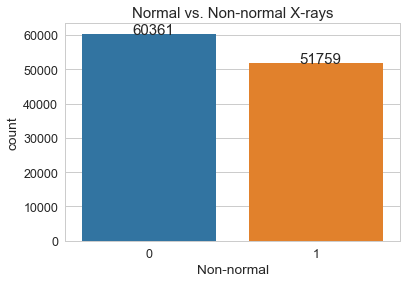

In [21]:
# increase font label size
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

# Plot normal v. non-normal X-ray counts
x = xrays['Non-normal']
ax = sns.countplot(x);

# label bars with counts
for p, label in zip(ax.patches, x.value_counts()):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.5))

plt.title('Normal vs. Non-normal X-rays')

# save PNG
plt.savefig('charts/countplot_normal_nonnormal.png', bbox_inches='tight')

**How many patients are there?**

In [22]:
# Count unique 'Patient ID'
p = xrays['Patient ID'].nunique()
print("Total Patients: {:,}".format(p))

puniqnonnorm = xrays[xrays['Non-normal'] == 1]['Patient ID'].nunique()
print("- Patients with Non-normal X-rays: {:,}".format(puniqnonnorm))

puniqnorm = xrays[xrays['Non-normal'] == 0]['Patient ID'].nunique()
print("- Patients with Normal X-rays: {:,}".format(puniqnorm))

Total Patients: 30,805
- Patients with Non-normal X-rays: 14,402
- Patients with Normal X-rays: 24,907


Observation: Many patients who have multiple X-rays must have both normal and non-normal results.

**How many of the patients with multiple X-rays have both normal and non-normal findings among those X-rays?**

In [ ]:
def fun_pcheck(p, df):
    '''Returns True if patient has both normal and non-normal X-rays'''
    patient = df[df['Patient ID'] == p]    
    if (len(patient['Non-normal'].unique()) == 1):
        return False # X-rays are all normal or all non-normal
    return True # X-rays have mixed results

In [ ]:
# IDs of patients with multiple X-rays
pids_multi = xrays[xrays['Follow-up #'] > 0]['Patient ID'].unique()

# subset columns
cols = ['Patient ID','Non-normal']
sub1 = xrays[cols]

# count of patients with combo results (norm/non)
pboth = 0
for p in pids_multi:    
    if (fun_pcheck(p, sub1) == True):
        pboth += 1

print('There are {:,} patients with more than one X-ray.'.format(len(pids_multi)))
print('Of these patients, {:,} have both normal and non-normal X-rays.'.format(pboth))
    

**As of the first x-ray, what are patients' ages?**

In [ ]:
# first X-ray
xr1 = xrays[xrays['Follow-up #'] == 0]
print("The plot below represents all {:,} patients.".format(xr1.shape[0]))

A benefit of only looking at the first X-ray is that each patient is counted once, as opposed to once per X-ray.

In [ ]:
# plot code adapted from sbernadac (Kaggle) to address the "first X-ray" question
sns.set(font_scale = 1.5)
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=xr1, kind="count",size=10, aspect=0.8,palette="husl");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Patient Age by Gender using 30,805 First X-rays,\nwhere Follow-up # is Zero',fontsize=22);
g.fig.subplots_adjust(top=.9)

# save chart as PNG
plt.savefig('charts/age_by_gender_first_xray.png', bbox_inches='tight')

In [ ]:
# count M and F in first xray
totalmen = xr1[xr1['Patient Gender'] == 'M']['Patient ID'].nunique()
totalmenxrays = xrays[xrays['Patient Gender'] == 'M']['Image Index'].nunique()
totalwommen = xr1[xr1['Patient Gender'] == 'F']['Patient ID'].nunique()
totalwomenxrays = xrays[xrays['Patient Gender'] == 'F']['Image Index'].nunique()
print('The dataset contains:')
print( '- {:,} X-rays from {:,} men.'.format(totalmenxrays, totalmen))
print( '- {:,} X-rays from {:,} wommen.'.format(totalwomenxrays, totalwommen))

In [ ]:
# plot code adapted from sbernadac (Kaggle)
sns.set(font_scale = 1.5)
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=xrays, kind="count",size=10, aspect=0.8,palette="husl");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Patient Age by Gender using All 112,120 X-rays',fontsize=22);
g.fig.subplots_adjust(top=.9)

# save chart as PNG
plt.savefig('charts/age_by_gender_all_xrays.png', bbox_inches='tight')

## Correlations

In [ ]:
# Enlarge the plot
plt.figure(figsize=(6,6))

# Calculate correlations
corr = xrays.iloc[:, 0:10].corr()

# Heatmap
sns.heatmap(corr, cmap='PiYG');

Insights from correlation plot:
- Total pathologies are most positively correlated with Effusion, Atelectasis, and Infiltration
- Total pathologies are least correlated with Hernia
- Image Width and Height are *negatively* correlated with Image Pixel Spacing

**Is there any correlation between Age and Follow-up #?**

In [ ]:
# Avg. Patient Age as of the 11th X-ray
xrays[xrays['Follow-up #'] == 10]['Patient Age'].mean(axis=0)

In [ ]:
# Compute average age of patients at each X-ray Follow-up #
maxfu = xrays['Follow-up #'].max(axis=0) # 183
fu = []   # follow-up number
favage = [] # avg. age
for f in range(maxfu):
    a = xrays[xrays['Follow-up #'] == f]['Patient Age'].mean(axis=0)
    fu.append(f)
    favage.append(a)

df_fufav = pd.DataFrame({'Follow-up #':fu, 'Average Age':favage})

In [ ]:
# Plot Average Age by Follow-up #
g = sns.lmplot(x='Follow-up #', y='Average Age', data=df_fufav);
plt.title('Average Age by Follow-up #');

In [ ]:
# plot with simple linear regression
sns.lmplot(x='Follow-up #', y='Patient Age', data=xrays,
           fit_reg=False, # No regression line
           hue='Patient Gender');

Observations:
* Follow-up # ranges from low of 0 (first visit) to high of 183 with a median of 3
* Patient Age ranges from 1 to 414; need to investigate extreme values
* 

Next, explore the variety of image widths, heights, and pixel spacing.

In [ ]:
# List categories and counts
for cat in ['Patient Gender', 'View Position']:
    print( "{}\n".format(xrays[cat].value_counts()) )

### X-ray image size and dimensions

In [ ]:
w = len(xrays["ImgWidth"].value_counts())
h = len(xrays["ImgHeight"].value_counts())
print("Unique image widths: {}\nUnique image heights: {}".format(w, h))

In [ ]:
# create column with combined image width by height string
xrays.loc[: ,"ImageWxH"] = xrays["ImgWidth"].map(str) + "x" + xrays["ImgHeight"].map(str)

In [ ]:
xrays["ImageWxH"].head()

In [ ]:
# summarize unique combinations of image dimensions
wh = len(xrays["ImageWxH"].value_counts())
print("Number of unique image dimensions (WxH) among chest X-rays: {}".format(wh))

In [ ]:
xrays["ImgWidth"].sort_values().tail()

In [ ]:
# histogram by Age
sns.distplot(xrays["ImgWidth"]*xrays["ImgHeight"]/1000000, bins=12,  kde=False);
plt.title('Histogram of X-ray Total Pixels, in Millions');

In [ ]:
# most common image dimensions
xrays["ImageWxH"].value_counts().head(10)

In [ ]:
x = len(xrays["ImgPxSpaceX"].value_counts())
y = len(xrays["ImgPxSpaceY"].value_counts())
print("Unique x pixel spacings: {}\nUnique y pixel spacings: {}".format(x, y))

## Exploratory Questions

* What are the overall age and gender distributions?
* What are the age and gender distributions by pathology?
* Are there correlations between "Follow-up #", Age, Gender, and Pathologies?


### Age analysis

In [ ]:
# histogram by Age
sns.distplot(xrays["Patient Age"], bins=25,  kde=False);
plt.title('Histogram of Patient Age with Full Data');

**What are the outliers at high end of 'Patient Age'?**

In [ ]:
xrays.iloc[:, 0:6].sort_values(by='Patient Age', ascending=False).head(20)

Finding: 16 X-rays list Patient Age of 148 or greater. Perhaps that value is mislabeled, or not 'years' in some instances. Look at same patient where possible.

In [ ]:
# Filter by 'Patient ID' where 'Patient Age' is over 100
xrays[xrays['Patient ID'].isin(xrays[xrays['Patient Age'] > 100]['Patient ID'])].tail(10)

Findings:
- Patient ID 25206 is Age 153 at Follow-up \#0, then Age 36 at all future Follow-ups.
- Patient ID 26028 is Age 60 at Follow-up \#0, but Age 154 at future Follow-ups.

**Age Outliers Conclusion:** A handful of 'Patient Age' outliers reveal errors in this data. In cases where an Age outlier Patient ID has matching Follow-up #'s, the Patient Age could be corrected on a case-by-case basis. This could improve EDA statistical summaries, or if Age were to be used as a data modeling input. Regardless, the rows for these X-ray images will be left in the data set.


In [ ]:
# histogram by Age < 100
sns.distplot(xrays[xrays["Patient Age"] < 100]["Patient Age"], bins=19,  kde=False);
plt.title('Histogram of Patient Age < 100');

### Follow-up # Analysis
**What is the range and distribution of "Follow-up #"?**

In [ ]:
# quick stats on multiple series
xrays[["TotalPathos", "Follow-up #"]].describe()

In [ ]:
# List top 20 X-ray counts by Follow-up #
a = xrays['Follow-up #']
unique_elements, counts_elements = np.unique(a, return_counts=True)

# counts_elements_proportion_of_patients
counts_elements_pop = counts_elements/counts_elements[0]
print("Frequency of unique values of the said array:")
#print(np.asarray((unique_elements, counts_elements)))
xrfu = pd.DataFrame( OrderedDict( {'Follow-up #':unique_elements, 'X-ray count':counts_elements, 'Proportion of patients':counts_elements_pop} ) )
xrfu.head(20)

In [ ]:
xrfu[30:36]

**Insights based on Follow-up #:**
- More than 90% of patients have fewer than 10 X-rays
- Fewer than 1% of patients have more than 35 X-rays

In [ ]:
x = xrays['Follow-up #']
plt.figure(figsize=(16, 9))
g = sns.countplot(x);
g.set_xticklabels(np.arange(min(x), max(x)+1, step=1));
#g.set_xticklabels(step=10);
plt.setp(g.get_xticklabels(), rotation=90);
plt.title('Count of X-rays by Follow-up #');

Insights:
* A given x-ray has anywhere from 0 to 9 total pathologies.
* The "Follow-up #" ranges from 0 (first visit and x-ray) to 183.

In [ ]:
%matplotlib inline

In [ ]:
x = xrays['TotalPathos']
sns.countplot(x);
plt.title('Count of X-rays by total number of pathologies found');

In [ ]:
# Plot of "Follow-up #" with 
sns.jointplot(x="Follow-up #", y="TotalPathos", data=xrays);

# References

As noted, some charts and code wizardry used here are credited to the excellent [Lung diseases data analysis](https://www.kaggle.com/sbernadac/lung-deseases-data-analysis) by Stephane Bernadec (sbernadec) on Kaggle.